In [4]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [5]:
%load_ext autoreload
%autoreload 2

In [2]:
from params import Params
import os

os.environ['KMD'] = '/media/andyli/dcist_acl1/kimera_multi/outdoor/'
os.environ['ROBOT'] = 'thoth'
params = Params.from_yaml('../config/kmd_demo.yaml')

print('loading data...')
cam_pose_data = params.load_camera_pose_data()
img_data = params.load_img_data()
depth_data = params.load_depth_data()
print('pose, img, depth data loaded')

times = img_data.times
N_frames = len(times)
imgs = [img_data.img(t) for t in times]
img_height, img_width = imgs[0].shape[:2]
depth_imgs = [depth_data.img(t) for t in times]
cam_poses = [cam_pose_data.pose(t) for t in times]

print(f'running algorithm on {N_frames} frames from t={times[0]} to t={times[-1]}')


loading data...
pose, img, depth data loaded
running algorithm on 897 frames from t=1666028177.903303 to t=1666028207.8622358


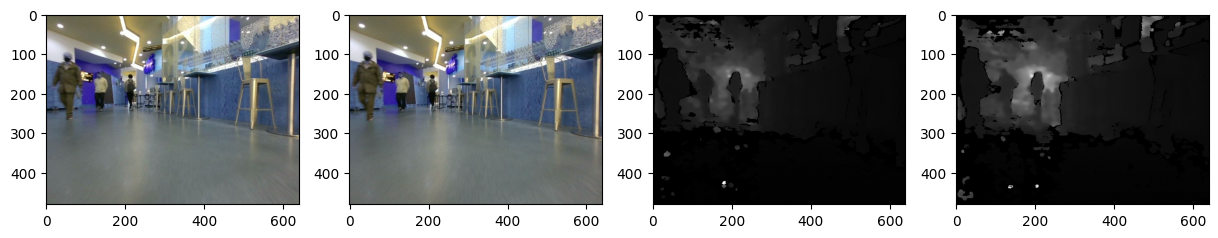

In [16]:
ind = 810
img0, img1 = imgs[ind], imgs[ind+1]
dimg0, dimg1 = depth_imgs[ind], depth_imgs[ind+1]
pose0, pose1 = cam_poses[ind], cam_poses[ind+1]

fig, axes = plt.subplots(1, 4, figsize=(15, 8))
axes[0].imshow(img0)
axes[1].imshow(img1)
axes[2].imshow(dimg0, cmap='gray')
axes[3].imshow(dimg1, cmap='gray')


### Geometric optical flow tests

In [5]:
def viz_optical_flow(flow):
    hsv = np.zeros((*flow.shape[:-1], 3), dtype=np.uint8)
    magnitude, angle = cv.cartToPolar(flow[..., 0], flow[..., 1])

    hsv[..., 0] = angle * 180 / np.pi / 2 # Hue corresponds to direction. OpenCV convention is 0-179
    hsv[..., 1] = 255  # Saturation is set to maximum
    hsv[..., 2] = cv.normalize(magnitude, None, 0, 255, cv.NORM_MINMAX)  # Value corresponds to magnitude
    flow_image = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)

    plt.figure(figsize=(10, 10))
    plt.imshow(flow_image)
    plt.title("Optical Flow")
    plt.axis("off")
    plt.show()

#### using open3d

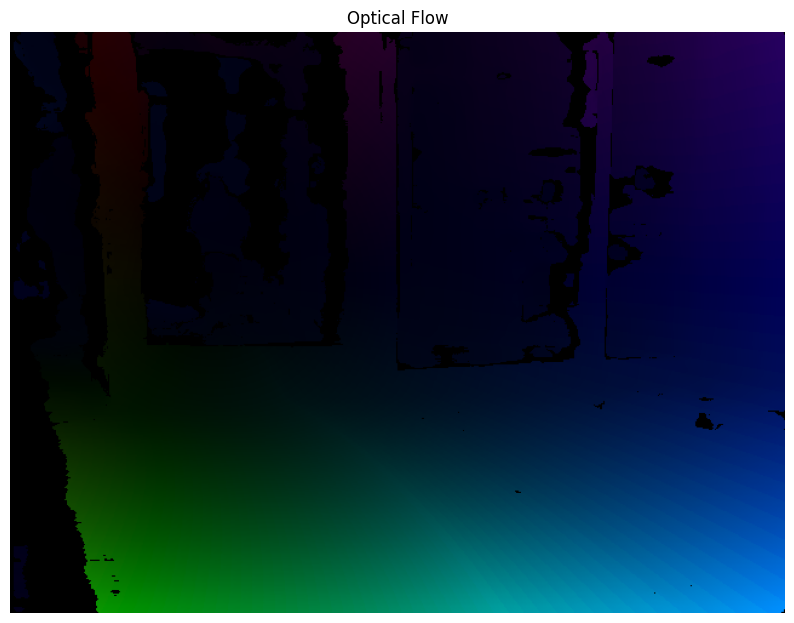

In [6]:
x, y = np.meshgrid(np.arange(img_width), np.arange(img_height))
pixel_coords = np.stack((x, y), axis=-1, dtype=np.float32)
pixel_coords_flattened = pixel_coords.reshape(-1, 2)

depth_cam_intrinsics = o3d.camera.PinholeCameraIntrinsic(
    width=int(depth_data.camera_params.width),
    height=int(depth_data.camera_params.height),
    fx=depth_data.camera_params.fx,
    fy=depth_data.camera_params.fy,
    cx=depth_data.camera_params.cx,
    cy=depth_data.camera_params.cy,
)

pcl_3d = o3d.geometry.PointCloud.create_from_depth_image(
    o3d.geometry.Image(np.ascontiguousarray(dimg0).astype(np.uint16)),
    depth_cam_intrinsics,
    depth_scale=1000,
    depth_trunc=20,
    stride=1,
    project_valid_depth_only=True
)

coords_3d = np.asarray(pcl_3d.points)

T_1_0 = np.linalg.inv(pose1) @ pose0 # T_w_1^-1 T_w_0: transform from frame 0 to frame 1

coords_3d_h = np.concatenate((coords_3d, np.ones((*coords_3d.shape[:-1], 1))), axis=-1)
coords_3d_h_1 = T_1_0 @ coords_3d_h.T
coords_3d_1 = (coords_3d_h_1.T)[:, :3]

projected_points, _ = cv.projectPoints(
    coords_3d_1, 
    rvec=np.zeros(3), tvec=np.zeros(3), 
    cameraMatrix=depth_data.camera_params.K, 
    distCoeffs=depth_data.camera_params.D,
)

projected_points = projected_points.reshape(-1, 2)

valid_mask = np.logical_and(dimg0 > 0, dimg0 < 20 * 1000)
valid_mask_flattened = valid_mask.flatten()
geometric_flow = np.zeros((*dimg0.shape, 2))

geometric_flow[valid_mask] = projected_points - pixel_coords_flattened[valid_mask_flattened]

viz_optical_flow(geometric_flow)

#### No o3d

In [ ]:
K, D = img_data.camera_params.K, img_data.camera_params.D

x, y = np.meshgrid(np.arange(img_width), np.arange(img_height))
pixel_coords = np.stack((x, y), axis=-1, dtype=np.float32)
pixel_coords_flattened = pixel_coords.reshape(-1, 2)

norm_cam_coords = cv.undistortPoints(pixel_coords_flattened, cameraMatrix=K, distCoeffs=D).reshape(-1, 2)

invalid_mask = np.logical_not(dimg0 > 0)
depths = dimg0.reshape(-1, 1) / 1000.0

coords_3d_xy = norm_cam_coords * depths
coords_3d = np.concatenate((coords_3d_xy, depths), axis=-1)


T_1_0 = np.linalg.inv(pose1) @ pose0 # T_w_1^-1 T_w_0: transform from frame 0 to frame 1

coords_3d_h = np.concatenate((coords_3d, np.ones((*coords_3d.shape[:-1], 1))), axis=-1)
coords_3d_h_1 = T_1_0 @ coords_3d_h.T
coords_3d_1 = (coords_3d_h_1.T)[:, :3]

projected_points, _ = cv.projectPoints(coords_3d_1, rvec=np.zeros(3), tvec=np.zeros(3), cameraMatrix=K, distCoeffs=D)

projected_points = projected_points.reshape(img_height, img_width, 2)

projected_points[invalid_mask] = pixel_coords[invalid_mask]

geometric_flow = projected_points - pixel_coords


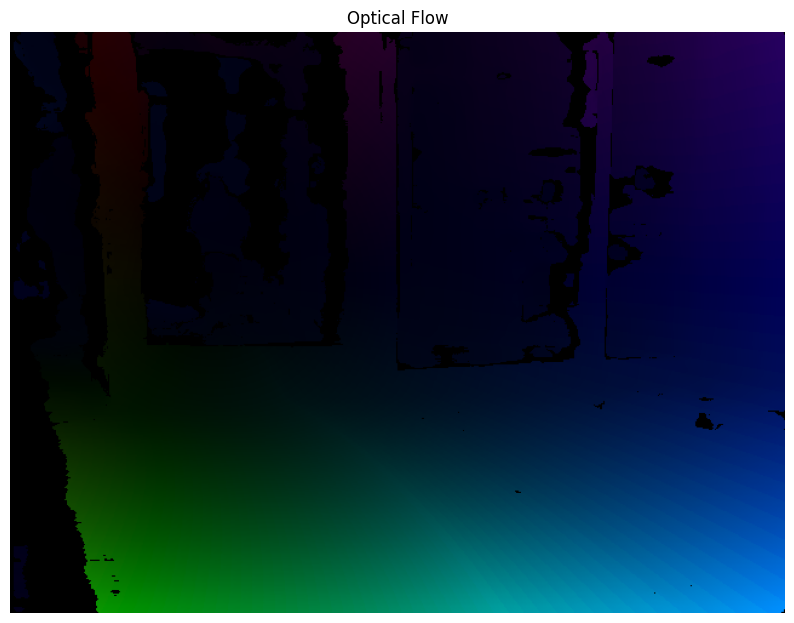

In [8]:
viz_optical_flow(geometric_flow)